# Project 3: Emotion detection with Neural Networks
## CS4740/5740 Fall 2020

Names: Wesley Ho, Phil Cipollina

Netids: wh395, pjc272

### Project Submission Due: November 13th
Please submit **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to project 1 instructions.



## Introduction
In this project we will consider **neural networks**: first a Feedforward Neural Network (FFNN) and second a Recurrent Neural Network (RNN), for performing a 5-class emotion detection task.

The project is divided into parts. In **Part 1**, you will be given an implementation for a FFNN and be asked to debug it in a specific way. In **Part 2**, you will then implement an RNN model for performing the same task. In **Part 3**, you will analyze these two models in two types of comparative studies and in **Part 4** you will answer questions describing what you have learned through this project. You also will be required to submit a description of libraries used, how your group divided up the work, and your feedback regarding the assignment (**Part 5**).

## Advice 🚀
As always, the report is important! The report is where you get to show
that you understand not only what you are doing but also why and how you are doing it. So be clear, organized and concise; avoid vagueness and excess verbiage. Spend time doing error analysis for the models. This is how you understand the advantages and drawbacks of the systems you build. The reports should read more like the papers that we have been writing critiques for.

All throughout the report you may be asked to place images, plots, etc. Feel free to write code that will generate the plots for you and use those or generate them some other way and insert into the colab. To add images in your colab, these are a few possible ways to do it!

1. Copy and paste the image in markdown! Yes this really does work

2. Upload to google drive, get a shareable link. It will be something like:

```
https://drive.google.com/file/d/1xDrydbSbijvK2JBftUz-5ovagN2B_RWH/view?usp=sharing
```
We want just the id which is `1xDrydbSbijvK2JBftUz-5ovagN2B_RWH` and the link we will use is:

```
https://drive.google.com/uc?export=view&id=your_id
```

Then in markdown you'd write the following:

```markdown
![image](https://drive.google.com/uc?export=view&id=1xDrydbSbijvK2JBftUz-5ovagN2B_RWH)
```

3. Using IPython!
```python
from IPython.display import Image
Image(filename="drive/GPU/data/iris.PNG")
```

4. Using your connected GDrive
```markdown
![iris](drive/GPU/data/iris.PNG)
```

## Dataset
You are given access to a set of tweets. These tweets have an associated
emotion $y \in Y := \{anger, fear, joy, love, sadness\}$. For this project, given the review text, you will
need to predict the associated rating, y. This is sometimes called fine-grained sentiment analysis in the literature; we will simply refer to it as sentiment analysis in this project.

We will minimally preprocess the reviews and handle tokenization in what we re-
lease. For this assignment, we do not anticipate any further preprocessing to be done by you. Should you choose to do so, it would be interesting to hear about in the report (along with whether or not it helped performance), but it is not a required aspect of the assignment.


In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

train_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "p3_train.txt") # replace based on your Google drive organization
val_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "p3_val.txt") # replace based on your Google drive organization
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "p3_test_no_labels.txt") # replace based on your Google drive organization

Mounted at /content/drive


# Part 1: Feedforward Neural Network

In this section, there are two main components relevant to **Part 1**.

1. `Data loader`\
As the name suggests, this section loads the data from the dataset files and handles other preprocessing and setup. You will **not** need to change this file and should **not** change this file throughout the assignment.

2. `ffnn`\
This contains the model and code that uses the model for **Part 1**

In the `ffnn` section, you will find a Feedforward Neural Net serving as the underlying model for performing emotion detection.



## Part 1: Tips

We do not assume you have **any** experience working with neural networks and/or debugging them. You may discover this process, while similar, is quite different from debuging in general software engineering and from debugging in other domains such as algorithms and systems.

We suggest you systematically step through the code and simultanously (perhaps by physically drawing it out) describe what the computations _mean_. What you are looking for is where the code differs from what is expected.

## Part 1: Rules

For **Part 1**, you will not be able to ask any questions on Piazza and we will be unable to provide any meaningful advice in office hours. Unfortunately, this is the nature of debugging, it is unlikely anyone can give you specific advice for most problems you encounter and we have already provided general tips in the preceding section, If you absolutely must ask a question or you believe there is some kind of issue with the assignment for this part, please submit a private Piazza post and we will respond swiftly.

As a reminder **communication about the assignment _between_ distinct groups is not permissed and is a violation of the Academic Integrity policy** For this assignment, we will be _extremely_ stringent about this, given that debugging is entirely pointless if someone else in a different group tells you where the error is.

## Import libraries and connect to Google Drive

In [2]:
!pip install --upgrade torch

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)


In [2]:
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import Dict, List, Set, Tuple
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt


## Data loader

In [3]:
emotion_to_idx = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    # "surprise": 5,
}
idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}
UNK = "<UNK>"

In [4]:
def fetch_data(train_data_path, val_data_path, test_data_path):
    """fetch_data retrieves the data from a json/csv and outputs the validation
    and training data

    :param train_data_path:
    :type train_data_path: str
    :return: Training, validation pair where the training is a list of document, label pairs
    :rtype: Tuple[
        List[Tuple[List[str], int]],
        List[Tuple[List[str], int]],
        List[List[str]]
    ]
    """
    with open(train_data_path) as training_f:
        training = training_f.read().split("\n")[1:-1]
    with open(val_data_path) as valid_f:
        validation = valid_f.read().split("\n")[1:-1]
    with open(test_data_path) as testing_f:
        testing = testing_f.read().split("\n")[1:-1]
	
    # If needed you can shrink the training and validation data to speed up somethings but this isn't always safe to do by setting k < 10000
    # k = #fill in
    # training = random.shuffle(training)
    # validation = random.shuffle(validation)
    # training, validation = training[:k], validation[:(k // 10)]

    tra = []
    val = []
    test = []
    for elt in training:
        if elt == '':
            continue
        txt, emotion = elt.split(",")
        tra.append((txt.split(" "), emotion_to_idx[emotion]))
    for elt in validation:
        if elt == '':
            continue
        txt, emotion = elt.split(",")
        val.append((txt.split(" "), emotion_to_idx[emotion]))
    for elt in testing:
        if elt == '':
            continue
        txt = elt
        test.append(txt.split(" "))

    return tra, val, test

In [5]:
def make_vocab(data):
    """make_vocab creates a set of vocab words that the model knows

    :param data: The list of documents that is used to make the vocabulary
    :type data: List[str]
    :returns: A set of strings corresponding to the vocabulary
    :rtype: Set[str]
    """
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab 


def make_indices(vocab):
	"""make_indices creates a 1-1 mapping of word and indices for a vocab.

	:param vocab: The strings corresponding to the vocabulary in train data.
	:type vocab: Set[str]
	:returns: A tuple containing the vocab, word2index, and index2word.
		vocab is a set of strings in the vocabulary including <UNK>.
		word2index is a dictionary mapping tokens to its index (0, ..., V-1)
		index2word is a dictionary inverting the mapping of word2index
	:rtype: Tuple[
		Set[str],
		Dict[str, int],
		Dict[int, str],
	]
	"""
	vocab_list = sorted(vocab)
	vocab_list.append(UNK)
	word2index = {}
	index2word = {}
	for index, word in enumerate(vocab_list):
		word2index[word] = index 
		index2word[index] = word 
	vocab.add(UNK)
	return vocab, word2index, index2word 


def convert_to_vector_representation(data, word2index, test=False):
	"""convert_to_vector_representation converts the list of strings into a vector

	:param data: The dataset to be converted into a vectorized format
	:type data: Union[
		List[Tuple[List[str], int]],
		List[str],
	]
	:param word2index: A mapping of word to index
	:type word2index: Dict[str, int]
	:returns: A list of vector representations of the input or pairs of vector
		representations with expected output
	:rtype: List[Tuple[torch.Tensor, int]] or List[torch.Tensor]

	List[Tuple[List[torch.Tensor], int]] or List[List[torch.Tensor]]
	"""
	if test:
		vectorized_data = []
		for document in data:
			vector = torch.zeros(len(word2index))
			for word in document:
				index = word2index.get(word, word2index[UNK])
				vector[index] += 1
			vectorized_data.append(vector)
	else:
		vectorized_data = []
		for document, y in data:
			vector = torch.zeros(len(word2index)) 
			for word in document:
				index = word2index.get(word, word2index[UNK])
				vector[index] += 1
			vectorized_data.append((vector, y))
	return vectorized_data

In [6]:
class EmotionDataset(Dataset):
    """EmotionDataset is a torch dataset to interact with the emotion data.

    :param data: The vectorized dataset with input and expected output values
    :type data: List[Tuple[List[torch.Tensor], int]]
    """
    def __init__(self, data):
        # print("tweet x10000 is:", data[10000][0].size())
        # print(data[10000])
        # print("x1 is:", data[1][0].size())
        # print(data[1])
        self.X = torch.cat([X.unsqueeze(0) for X, _ in data])
        self.y = torch.LongTensor([y for _, y in data])
        self.len = len(data)
    
    def __len__(self):
        """__len__ returns the number of samples in the dataset.

        :returns: number of samples in dataset
        :rtype: int
        """
        return self.len
    
    def __getitem__(self, index):
        """__getitem__ returns the tensor, output pair for a given index

        :param index: index within dataset to return
        :type index: int
        :returns: A tuple (x, y) where x is model input and y is our label
        :rtype: Tuple[torch.Tensor, int]
        """
        return self.X[index], self.y[index]

def get_data_loaders(train, val, batch_size=16):
    """
    """
    # First we create the dataset given our train and validation lists
    dataset = EmotionDataset(train + val)

    # Then, we create a list of indices for all samples in the dataset
    train_indices = [i for i in range(len(train))]
    val_indices = [i for i in range(len(train), len(train) + len(val))]

    # Now we define samplers and loaders for train and val
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [7]:
train, val, test = fetch_data(train_path, val_path, test_path)

In [8]:
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = convert_to_vector_representation(train, word2index)
val_vectorized = convert_to_vector_representation(val, word2index)
test_vectorized = convert_to_vector_representation(test, word2index, True)

In [9]:
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=1)

In [ ]:
# Note: Colab has 12 hour limits on GPUs, also potential inactivity may kill the notebook. Save often!

## 1.1 FFNN Implementation

### 1.1 Task
Assume that an onmiscient oracle has told you there are **4 fundamental errors** in the **FFNN** implementation. They may be anywhere in this section unless otherwise indicated. Your objective is to _find_ and _fix_ each of these errors and to include in the report a description of the original error along with the fix. To help your efforts, the oracle has provided you with additional information about the properties of the errors as follows:

* _Correctness_ \
Each error causes the code to be strictly incorrect. There is absolutely no ambiguity that the errant code (or missing code) is incorrect. This means errors are not due to the code being inefficient (in run-time or in memory).

* _Localized_ \
Each error can be judged to be erroneous by strictly looking at the code (along with your knowledge of machine learning as taught through this course). The errors therefore are not due to the model being uncompetitive in terms of performance with state-of-the-art performance for this task nor are they due to the amount of data being insufficient for this task in general.

* _General_ \
Each error is general in nature. They will not be triggered by the model receiving a pathological input, i.e. they will not be something that is triggered specifically when NLP is referenced with negative sentiment.

* _Fundamental_ \
Each error is a fundamental failure in terms of doing what is intended. This means that errors do not hinge on nuanced understanding of specific PyTorch functionality. This also means they will not exploit properties of the dataset in
a subtle way that could only be realized by someone who has comprehensively studied the data.

The bottom line: the errors should be fairly obvious. The oracle further reminds you that performance/accuracy of the (resulting) model should not be how you ensure you have debugged successfully. For example, if you correct some, but not all, of the errors, the remaining errors may mask the impact of your fixes. Further, performance is not guaranteed to improve by fixing any particular error. Consider the case where the training set is also employed as the test set; performance will be very high but there is something very wrong. And fixing the problem will reduce performance.
In fixing each error, the oracle provides some further insight about the fixes:

* _Minimal_ \
A reasonable fix for each error can be achieved in < 5 lines of code being changes. We do not require you to make fixes of 4 of fewer lines, but it should be a cause for concern if your fixes are far more elaborate

* _Ill-posed_ \
While the errors are unambiguous, the method for fixing them is under-specified: You are free to implement any reasonable fix and all such fixes will equally recieve full credit.

In [10]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [11]:
unk = '<UNK>'

# Consult the PyTorch documentation for information on the functions used below:
# https://pytorch.org/docs/stable/torch.html

class FFNN(nn.Module):
	def __init__(self, input_dim, h, output_dim):
		super(FFNN, self).__init__()
		self.h = h
		self.W1 = nn.Linear(input_dim, h)
		self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
		self.W2 = nn.Linear(h, output_dim) # error #2, timestamp 25:47 torch tutorial vid maybe?
    # The below two lines are not a source for an error
		self.softmax = nn.LogSoftmax(dim=1) # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
		self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

	def compute_Loss(self, predicted_vector, gold_label):
		return self.loss(predicted_vector, gold_label)

	def forward(self, input_vector):
		# The z_i are just there to record intermediary computations for your clarity
		z1 = self.W1(input_vector)
		# 27:10 z1 = self.activation(z1) maybe? error 3
		z1 = self.activation(z1)
		z2 = self.W2(z1)
		predicted_vector = self.softmax(z2)
		return predicted_vector
	
	def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
	
	def save_model(self, save_path):
		torch.save(self.state_dict(), save_path)


def train_epoch(model, train_loader, optimizer):
	model.train()
	total = 0
	loss = 0
	correct = 0
	for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
		output = model(input_batch.to(get_device()))
		# print(output)
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out == predicted.to("cpu")).cpu().numpy().sum()
		loss = model.compute_Loss(output, expected_out.to(get_device()))
		#46:16 possible 4th error: didn't zero_grad optimizer
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	# Print accuracy
	acc = correct / total
	print("training accuracy:", acc)
	loss = loss.tolist()
	print("training loss:", loss)
	return acc, loss


def evaluation(model, val_loader, optimizer):
	model.eval()
	loss = 0
	correct = 0
	total = 0
	for (input_batch, expected_out) in tqdm(val_loader, leave=False, desc="Validation Batches"):
		output = model(input_batch.to(get_device()))
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
		loss += model.compute_Loss(output, expected_out.to(get_device()))
	loss /= len(val_loader)
	# Print validation metrics
	acc = correct / total
	print("evaluation acc", correct / total)
	loss = loss.tolist()
	print("evaluation loss", loss)
	return acc, loss

def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
	print(model.parameters())
	# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
	optimizer = optim.Adam(model.parameters(), lr=0.0003)
	trainacc = []
	trainloss = []
	evalacc = []
	evalloss = []
	for epoch in trange(number_of_epochs, desc="Epochs"):
		t = time.time()
		acc, loss = train_epoch(model, train_loader, optimizer) #error 1
		trainacc.append(acc)
		trainloss.append(loss)
		acc, loss = evaluation(model, val_loader, optimizer)
		evalacc.append(acc)
		evalloss.append(loss)
		print("this epoch took", str(time.time() - t), "seconds")
	return trainacc, trainloss, evalacc, evalloss

In [ ]:
h = 512
model = FFNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
trainacc, trainloss, evalacc, evalloss = train_and_evaluate(2, model, train_loader, val_loader)
print(trainacc, trainloss, evalacc, evalloss)
model.save_model("ffnn_fixed.pth") # Save our model!

In [ ]:
# Example of how to load
h=512
loaded_model = FFNN(len(vocab), h, len(emotion_to_idx))
loaded_model.load_model("ffnn_fixed.pth")

## 1.2 Part 1 Report
Please include a description of the error, a description of your fix, and a python comment indicating the fix for each of the 4 errors.

### Error 1:
```
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
	optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
	for epoch in trange(number_of_epochs, desc="Epochs"):
		train_epoch(model, val_loader, optimizer)
		evaluation(model, val_loader, optimizer)
	return
```
This section of code was initially incorrect because of its use of val_loader in the train_epoch function. It should use train_loader instead and look like the following:
```
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
	optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
	for epoch in trange(number_of_epochs, desc="Epochs"):
		train_epoch(model, train_loader, optimizer)
		evaluation(model, val_loader, optimizer)
	return
```

### Error 2:
```
def __init__(self, input_dim, h, output_dim):
	super(FFNN, self).__init__()
	self.h = h
	self.W1 = nn.Linear(input_dim, h)
	self.activation = nn.ReLU()choice of activation function
	self.W2 = nn.Linear(h, h)
	self.softmax = nn.LogSoftmax(dim=1) 
	self.loss = nn.NLLLoss()
```
This section of code was initially incorrect because W2 is initialized with incorrect dimensions. We fixed it by initializing it with the correct dimensions, h x output_dim:
```
def __init__(self, input_dim, h, output_dim):
	super(FFNN, self).__init__()
	self.h = h
	self.W1 = nn.Linear(input_dim, h)
	self.activation = nn.ReLU()
	self.W2 = nn.Linear(h, output_dim) # error #2
	self.softmax = nn.LogSoftmax(dim=1)
	self.loss = nn.NLLLoss()
```

### Error 3:
```
	def forward(self, input_vector):
		z1 = self.W1(input_vector)
		z2 = self.W2(z1)
		predicted_vector = self.softmax(z2)
		return predicted_vector
```
This section of code was initially incorrect because z1 is not put through the activation function. We fixed it by applying the activation function to z1:
```
	def forward(self, input_vector):
		z1 = self.W1(input_vector)
		z1 = self.activation(z1)
		z2 = self.W2(z1)
		predicted_vector = self.softmax(z2)
		return predicted_vector
```


### Error 4:
```
def train_epoch(model, train_loader, optimizer):
	model.train()
	total = 0
	loss = 0
	correct = 0
	for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
		output = model(input_batch.to(get_device()))
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out == predicted.to("cpu")).cpu().numpy().sum()
		loss = model.compute_Loss(output, expected_out.to(get_device()))
		loss.backward()
		optimizer.step()
	return
```
This section of code was initially incorrect because we forget to initialize the optimize gradient to zeros. We fixed it by using the torch function zero_grad() to do so:
```
def train_epoch(model, train_loader, optimizer):
	model.train()
	total = 0
	loss = 0
	correct = 0
	for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
		output = model(input_batch.to(get_device()))
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out == predicted.to("cpu")).cpu().numpy().sum()
		loss = model.compute_Loss(output, expected_out.to(get_device()))
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	print("training accuracy:", loss)
	return
```

# Part 2: Recurrent Neural Network
Recurrent neural networks have been the workhorse of NLP for a number of years. A fundamental reason for this success is they can inherently deal with _variable_ length sequences. This is axiomatically important for natural language; words are formed from a variable number of characters, sentences from a variable number of words, paragraphs from a variable number of sentences, and so forth. This differs from a field like Computer Vision where images are (generally) of a fixed size.
<br></br>
This is also very different scenario than that of the classifiers we have studied (e.g.Naive Bayes, Perceptron Learning, Feedforward Neural Networks), which take in a
fixed-length vector.
<br></br>
To clarify this, we can think of the _types_ of the mathematical functions described by a FFNN and an RNN. What is pivotal in what follows is that k need not be constant
across examples.

$\textbf{FFNN.}$ \
$Input: \vec{x} \in \mathcal{R}^d$ \
$Model\text{ }Output: \vec{z} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$
$Final\text{ }Output: \vec{y} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$ \
$\vec{y}$ satisfies the contraint of being a probability distribution, ie $\underset{i \in \mid \mathcal{Y} \mid}{\sum} \vec{y}[i] = 1$ and $\underset{i \in \mid \mathcal{y} \mid}{min} \text{ }\vec{y}[i] \leq 1$, which is achieved via _Softmax_ applied to $\vec{z}$.
<br></br>
$\textbf{RNN.}$ \
$Input: \vec{x}_1,\vec{x}_2, \dots, \vec{x}_k; \vec{x}_i \in \mathcal{R}^d$ \
$Model\text{ }Output: \vec{z}_1,\vec{z}_2, \dots, \vec{z}_k; \vec{z}_i \in \mathcal{R}^{h}$
$Final\text{ }Output: \vec{y} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$ \
$\vec{y}$ satisfies the contraint of being a probability distribution, ie $\underset{i \in \mid \mathcal{Y} \mid}{\sum} \vec{y}[i] = 1$ and $\underset{i \in \mid \mathcal{y} \mid}{min} \text{ }\vec{y}[i] \geq 0$, which is achieved by the process described later in this report and as you have seen in class

Intuitively, an RNN takes in a sequence of vectors and computes a new vector corresponding to each vector in the original sequence. It achieves this by processing the input sequence one vector at a time to (a) compute an updated representation of the entire sequence (which is then re-used when processing the next vector in the input sequence), and (b) produce an output for the current position. The vector computed in (a) therefore not only contains information about the current input vector but also about the previous input vectors. Hence, $\vec{z}_j$ is computed after having observed $\vec{x}_1, \dots, \vec{x}_j$. As such, a simple observation is we can treat the last vector computed by the RNN, ie $\vec{z}_k$ as a representation of the entire sequence. Accordingly, we can use this as the input to a single-layer linear classifier to compute a yector $\vec{y}$ as we will need for classification.

$$\vec{y} = Softmax(W\vec{z}_k); W\in \mathcal{R}^{\mid \mathcal{Y}\mid \times h}$$

## Part 2: Rules
**Part 2** requires implementing a rudimentary RNN in PyTorch for text classification. Countless blog posts, internet tutorials and other implementations available publicly (and privately) do precisely this. In fact, almost every student in [Cornell NLP](https://nlp.cornell.edu/people/) likely has some code for doing this on their Github. You **cannot** use any such code (though you may use anything you find in course notes or course texts) irrespective of whether you cite it or do not.

Submissions will be passed through the MOSS system, which is a sophisticated system for detecting plagiarism in code and is robust in the sense that it tries to find alignments in the underlying semantics of the code and not just the surface level syntax. Similarly, the course staff are also quite astute with respect to programming neural models for NLP and we will strenuously look at your code. We flagged multiple groups for this last year, so we strongly suggest you resist any such temptation (if the Academic Integrity policy alone is insufficient at dissuading you).

## 2.1 RNN Implementation

Similar to **Part 1**, we have the previous `Data loader` section and the new `RNN` component. We don't envision that it will be useful to modify the `Data loader`. We have included some stubs to help give you a place to start for the RNN.

Additionally, we remind you that Part 1 furnishes a near-functional implementation of a similar neural model for the same task. If you successfully do Part 1 correctly, it will be wholely functional. Using it as a template for Part 2 is both prudent and suggested.

In [12]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [13]:
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.300d.txt") # replace based on your Google drive organization


In [14]:
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
# glove = pd.read_csv("glove.6B.50d.txt", sep=" ", quoting=3, header=None, index_col=0)

glove_embedding = {key: val.values for key, val in glove.T.items()}

In [15]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))

  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
  return embedding_matrix

In [16]:
embMatrix = create_embedding_matrix(word2index, glove_embedding, 300)

In [17]:
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)

In [18]:
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))


In [19]:
def rnn_preprocessing(data, embedding, word2index, test=False, embeddim=50):
    """rnn_preprocessing

    :param data:
    :type data:
    :param test:
    :type test:
    """
    # Do some preprocessing similar to convert_to_vector_representation
    # For the RNN, remember that instead of a single vector per training
    # example, you will have a sequence of vectors where each vector
    # represents some information about a specific token.
    vocabsize = len(word2index)
    # embeddim = 50
    maxtweetlength = 140 # the max number of words in a tweet is 140
    if test:
      vectorized_data = []
      for document in data:
        idxs = []
        for word in document:
          idxs.append(word2index.get(word, word2index[UNK]))
        idxs = torch.tensor(idxs, dtype=torch.long)
        ems2 = embedding(idxs)
        tensd = maxtweetlength - ems2.size()[0]
        tens0 = torch.zeros(tensd, embeddim)
        ems = torch.cat((ems2, tens0), 0)
        vectorized_data.append(ems)
      # for tensi in range(len(vectorized_data)):
      #   # tens = (torch.zeros(maxtweetlength) +  tens[0], tens[1])
      #   tens = vectorized_data[tensi]
      #   tensd = maxtweetlength - tens.size()[0]
      #   tens0 = torch.zeros(tensd, 50)
      #   vectorized_data[tensi] = torch.cat((tens, tens0),0)
    else:
      vectorized_data = []
      for document, label in data:
        idxs = []
        for word in document:
          idxs.append(word2index.get(word, word2index[UNK]))
        idxs = torch.tensor(idxs, dtype=torch.long)
        ems2 = embedding(idxs)
        tensd = maxtweetlength - ems2.size()[0]
        tens0 = torch.zeros(tensd, embeddim)
        ems = torch.cat((ems2, tens0), 0)
        vectorized_data.append((ems, label))
      # for tensi in range(len(vectorized_data)):
      #   # tens = (torch.zeros(maxtweetlength) +  tens[0], tens[1])
      #   tens = vectorized_data[tensi]
      #   tensd = maxtweetlength - tens[0].size()[0]
      #   tens0 = torch.zeros(tensd, 50)
      #   vectorized_data[tensi] = (torch.cat((tens[0], tens0),0), tens[1])
    return vectorized_data

### RNN class

In [126]:
class RNN(nn.Module):
	def __init__(self, input_dim, h, output_dim, embeddim=50): # Add relevant parameters
		super(RNN, self).__init__()#input_dim, h)
		# Fill in relevant parameters
		self.h = h
		self.output_dim=output_dim
		self.W3 = nn.Linear(h, output_dim) # V
		self.W3.to(get_device())
		self.rnn = nn.RNN(embeddim, h, num_layers=3, nonlinearity='relu')
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
		self.softmax = nn.LogSoftmax(dim=1)
		self.loss = nn.NLLLoss()
		self.embeddim = embeddim

	def compute_Loss(self, predicted_vector, gold_label):    
		return self.loss(predicted_vector, gold_label)	

	def forward(self, inputs):
		# print('inputszie19', inputs.size())
		# begin code
		# print("start fwd")
		bs = inputs.size()[0]
		last = [-1]*bs
		for batch in range(bs):
			b = 1
			for tweet in range(inputs.size()[1]):
				currtweet = inputs[batch][tweet]
				# if tweet < 5:
					# print(currtweet)
				if torch.abs(currtweet).sum() <= 0.1 and b == 1:
					last[batch] = tweet
					b = 0
				if b == 0:
					break
		outputs, h_n = self.rnn(inputs)
		#only pass in the final layer
		h2 = self.W3(outputs[-1:])
		predicted_vector = self.softmax(h2) # remember to include the predicted 
		# print(predicted_vector.size())
		# print('predictedvecl41', predicted_vector)
		pv = torch.zeros(bs,5).to(get_device())
		i = 0
		for batch in predicted_vector:
			concatted = torch.unsqueeze(batch[last[i-1]],0)
			# print('concatted', concatted, 'pv', pv)
			pv[i] = concatted
			i +=1
		# print("pvl47", pv)
		# print("pv", type(pv), pv.size(), pv)
		# unnormalized scores which should be normalized into a (log) probability distribution
		# end code
		return pv

	def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
	
	def save_model(self, save_path):
		torch.save(self.state_dict(), save_path)

### other rnn stuff

In [49]:
class RNN(nn.RNN):
	def __init__(self, input_dim, h, output_dim, embeddim=50): # Add relevant parameters
		super(RNN, self).__init__(input_dim, h)
		# Fill in relevant parameters
		self.h = h
		self.output_dim=output_dim
		self.W3 = nn.Linear(h, output_dim) # V
		self.rnn = nn.RNN(embeddim, h, num_layers=3, nonlinearity='relu')
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
		self.softmax = nn.LogSoftmax(dim=1)
		self.loss = nn.NLLLoss()
		self.embeddim = embeddim

	def compute_Loss(self, predicted_vector, gold_label):    
		return self.loss(predicted_vector, gold_label)	

	def forward(self, inputs):
		# print('inputszie19', inputs.size())
		# begin code
		# print("start fwd")
		bs = inputs.size()[0]
		last = [-1]*bs
		for batch in range(bs):
			b = 1
			for tweet in range(inputs.size()[1]):
				currtweet = inputs[batch][tweet]
				# if tweet < 5:
					# print(currtweet)
				if torch.abs(currtweet).sum() <= 0.1 and b == 1:
					last[batch] = tweet
					b = 0
				if b == 0:
					break
		inputs = inputs.to(get_device())
		outputs, h_n = self.rnn(inputs) #outputs is size [batchsize, inputlength, h(numfeatures)]
		i = 0; pv = torch.zeros(bs, self.h).to(get_device())
    #pv = torch.zeros(bs,512).to(get_device())
		for batch in outputs:
			concatted = torch.unsqueeze(batch[last[i-1]],0)
			# print('concatted', concatted, 'pv', pv)
			pv[i] = concatted
			i +=1
		#only pass in the final layer
		h2 = self.W3(pv)
		predicted_vector = self.softmax(h2) # remember to include the predicted 
		# print(predicted_vector.size())
		# print('predictedvecl41', predicted_vector)
		
		# print("pvl47", pv)
		# print("pv", type(pv), pv.size(), pv)
		# unnormalized scores which should be normalized into a (log) probability distribution
		# end code
		return predicted_vector

	def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
	
	def save_model(self, save_path):
		torch.save(self.state_dict(), save_path)

In [21]:
train, val, test = fetch_data(train_path, val_path, test_path)

In [22]:
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index, embeddim=300)
val_vectorized = rnn_preprocessing(val, embedding, word2index, embeddim=300)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True, embeddim=300)

In [23]:
# print(len(train_vectorized))
# print(len(val_vectorized))
# print(len(test_vectorized[0]))
# print(test_vectorized[0])

In [24]:
def train_rnn_epoch(model, train_loader, optimizer):
  model.train()
  total = 0
  loss = 0
  correct = 0
  cbatch = 0
  ctest = 0
  pred_list = torch.tensor([]).to(get_device())
  exp_list = torch.tensor([])
  for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
    # print('ib', input_batch.size(), input_batch)
    optimizer.zero_grad()
    cbatch += 1
    output = model(torch.autograd.Variable(input_batch).to(get_device()))
    total += output.size()[0]
    p1, predicted = torch.max(output, 1)
    pred_list = torch.cat((pred_list,predicted),0)
    exp_list = torch.cat((exp_list,expected_out),0)
    ctest += predicted.to("cpu").sum()
    correct += (expected_out == predicted.to("cpu")).cpu().numpy().sum()
    loss = model.compute_Loss(output, expected_out.to(get_device()))
    # optimizer.zero_grad()
    loss.backward()
    # print('ih',torch.norm(model.rnn.weight_ih_l0.grad))
    # print('hh',torch.norm(model.rnn.weight_hh_l0.grad))
    # print('W3',torch.norm(model.W3.weight.grad))
    optimizer.step()
    # print('loss', loss)
    # print("acc", str((expected_out == predicted.to("cpu")).cpu().numpy().sum()/expected_out.size()[0]))
  # print("cbatch", cbatch)
  # print("ctest", ctest)
  cacc = correct/total
  print("\ntraining accuracy:{:.2%}".format(cacc))
  # print("correct", correct, "total", total)
  loss = loss.tolist()
  print("training loss:", loss)
  # print('pred list',pred_list)
  # pplst = pred_list.type(torch.int)
  # binc = torch.bincount(pplst)
  # print('predlist bincount', binc)
  # print('exp list',exp_list)
  # explst = exp_list.type(torch.int)
  # binc2 = torch.bincount(explst)
  # print('explist bincount', binc2)
  return cacc, loss

def rnn_evaluation(model, val_loader, optimizer):
  model.eval()
  loss = 0
  correct = 0
  total = 0
  for (input_batch, expected_out) in tqdm(val_loader, leave=False, desc="Validation Batches"):
    output = model(input_batch.to(get_device()))
    total += output.size()[0]
    _, predicted = torch.max(output, 1)
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
    loss += model.compute_Loss(output, expected_out.to(get_device()))
  loss /= len(val_loader)
	# Print validation metrics
  cacc = correct/total
  print("evaluation acc:{:.2%}".format(cacc))
  loss = loss.tolist()
  print("evaluation loss:", loss)
  return cacc, loss

def train_and_evaluate_rnn(number_of_epochs, model, train_loader, val_loader):
  optimizer = optim.Adam(model.parameters(), lr=0.0003)
  trainacc = []
  trainloss = []
  evalacc = []
  evalloss = []
  for epoch in trange(number_of_epochs, desc="Epochs"):
    t = time.time()
    cacc, loss = train_rnn_epoch(model, train_loader, optimizer)
    trainacc.append(cacc)
    trainloss.append(loss)
    cacc, loss = rnn_evaluation(model, val_loader, optimizer)
    evalacc.append(cacc)
    evalloss.append(loss)
    print("this epoch took", str(round(time.time()-t,2)), "seconds")
  return trainacc, trainloss, evalacc, evalloss

In [25]:
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=128)

In [26]:
# print(train_loader)

In [ ]:
h = 512
model = RNN(len(vocab), h, len(emotion_to_idx), embeddim=300).to(get_device())
# model = nn.RNN(len(vocab), h).to(get_device())
# model = nn.RNN(50, h).to(get_device())
trainacc, trainloss, evalacc, evalloss = train_and_evaluate_rnn(2, model, train_loader, val_loader)
print(trainacc, trainloss, evalacc, evalloss)
model.save_model("rnn_fixed.pth") # Save our model!

In [ ]:
# Example of how to load
loaded_model = FFNN(len(vocab), h, len(emotion_to_idx))
loaded_model.load_model("ffnn_fixed.pth")

## 2.2 Part 2 Report
For Part 2, your report should have a description of each major step of implementing the RNN accompanied by the associated code-snippet. Each step should have an explanation for why you decided to do something (when one could reasonably do the same step in a different way); your justification will not be based on empirical results in this section but should relate to something we said in class, something mentioned in any of the course texts, or some other source (i.e. literature in NLP or official PyTorch documentation). **Unjustified, vague, and/or under-substantiated explanations will not receive credit.**

Things to include:

1. _Representation_ \
Each $\vec{x}_i$ needs to be produced in some way and should correspond to word $i$ in the text. This is different from the text classification approaches we have studied previously (BoW for example) where the entire document is represented with a single vector. Where and how is this being done for the RNN?

2. _Initialization_ \
There will be weights that you update in training the RNN. Where and how are these initialized?

3. _Training_ \
You are given the entire training set of N examples. How do you make use of this training set? How does the model modify its weights in training (this likely entails somewhere where gradients are computed and somehwere else where these gradients are used to update the model)?

4. _Model_ \
This is the core model code, ie. where and how you apply the RNN to the $\vec{x}_i$

5. _Linear Classifier_ \
Given the outputs of the RNN, how do you consume these to actually compute $\vec{y}$?

6. _Stopping_ \
How does your training procedure terminate?

7. _Hyperparameters_ \
To run your model, you must fix some hyperparameters, such as $h$ (the hidden dimensionality of the $\vec{z}_i$ referenced above). Be sure to exhaustively describe these hyperparameters and why you set them as you did ( this almost certainly will require some brief exploration: we suggest the course text by Yoav Goldberg as well as possibly the PyTorch official documentation). Be sure to accurately cite either source.



### 2.2.1 Representation


In order to represent each tweet as a vector of vectors, we used a Glove dataset and nn.embeddings to create an embedding for each word in a tweet, with each embedding being comprised of 50 features. The embeddings and representations are created as part of preprocessing, with the embeddings matrix used to create the word embeddings of words in the dataset done separately from the actual creation of the dataset embeddings.

```
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))

  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
  return embedding_matrix

embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)

emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]

embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
```

```
def rnn_preprocessing(data, embedding, word2index, test=False):
    """rnn_preprocessing

    :param data:
    :type data:
    :param test:
    :type test:
    """
    # Do some preprocessing similar to convert_to_vector_representation
    # For the RNN, remember that instead of a single vector per training
    # example, you will have a sequence of vectors where each vector
    # represents some information about a specific token.
    vocabsize = len(word2index)
    maxtweetlength = 140 # the max number of words in a tweet is 140
    if test:
      vectorized_data = []
      for document in data:
        idxs = []
        for word in document:
          idxs.append(word2index.get(word, word2index[UNK]))
        idxs = torch.tensor(idxs, dtype=torch.long)
        ems2 = embedding(idxs)
        tensd = maxtweetlength - ems2.size()[0]
        tens0 = torch.zeros(tensd, 50)
        ems = torch.cat((ems2, tens0), 0)
        vectorized_data.append(ems)
    else:
      vectorized_data = []
      for document, label in data:
        idxs = []
        for word in document:
          idxs.append(word2index.get(word, word2index[UNK]))
        idxs = torch.tensor(idxs, dtype=torch.long)
        ems2 = embedding(idxs)
        tensd = maxtweetlength - ems2.size()[0]
        tens0 = torch.zeros(tensd, 50)
        ems = torch.cat((ems2, tens0), 0)
        vectorized_data.append((ems, label))
    return vectorized_data
```




### 2.2.2 Initialization


To create our rnn, we used the built-in nn.RNN and nn.Linear, which take care of the creation of the weight matrices in their code.  As a result, the weight matrices are initialized in our RNN class as part of the nn.rnn call in forward, followed by using nn.Linear for the final linear weight matrix. Softmax and loss are also initialized here for later use in training/evaluating.

```
def __init__(self, input_dim, h, output_dim): # Add relevant parameters
		super(RNN, self).__init__()#input_dim, h)
		# Fill in relevant parameters
		self.h = h
		self.output_dim=output_dim
		self.W3 = nn.Linear(h, output_dim) # V
		self.W3.to(get_device())
		self.rnn = nn.RNN(50, h)
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
		self.softmax = nn.LogSoftmax(dim=1)
		self.loss = nn.NLLLoss()
```

### 2.2.3 Training


We make use of the training set via the provided fetch_data and get_data_loaders functions as well as through the provided make_vocab and make_indices functions. 

```
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
```

The model modifies its weights using an SGD optimizer that was created with the line 
```
	optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
```
in train_rnn_epoch and updates the weights using the optim's .step() function.

### 2.2.4 Model


We apply the model by calling it in train_rnn_epoch with the line:

```
output = model(torch.autograd.Variable(input_batch).to(get_device()))
```
More specifically, this line runs our forward function in our RNN class. This function begins by finding the length of the original tweet so that later, we can grab the predicted value from the true end of the sequence rather than the end of the padded sequence. The function then runs the inputs through the nn.rnn function, puts this output through the linear layer to get the final output layer, softmaxes this output to get the probabilities, and lastly, returns the predicted values found at the true end of the sequence.

```
def forward(self, inputs):
		zeros = torch.zeros(50).to(get_device())
		bs = inputs.size()[0]
		last = [-1]*bs
		b = 1
		for batch in range(bs):
			for tweet in range(inputs.size()[1]):
				currtweet = inputs[batch][tweet]
				if torch.abs(currtweet).sum() <= 0.1 and b == 1:
					last[batch] = tweet
					b = 0
				if b == 0:
					break
			if b == 0:
				break
		outputs, h_n = self.rnn(inputs)
		h2 = self.W3(outputs)
		predicted_vector = self.softmax(h2) # remember to include the predicted 
		pv = torch.tensor([[]]).to(get_device())
		i = 0
		for batch in predicted_vector:
			pv= torch.cat((pv,torch.unsqueeze(batch[last[i]],0)),1)
			i +=1
		return pv
```


### 2.2.5 Linear Classifier

Given the outputs of nn.RNN, we then run it through the linear layer as mentioned above and softmax this result to get the predicted vector. Later, outside of our rnn model, we take the predicted vector as the output and find the max of the vector using the following:
```
_, predicted = torch.max(output, 0)
```
This line finds the max of the predicted vector. This result should be our final prediction answer.

### 2.2.6 Stopping


Our model stops training after running a predetermined number of epochs.

### 2.2.7 Hyperparameters


Our hyperparameters include:

*   h: the number of hidden layers
*   embed_dim: the number of features embedded
*   batch_size: the number of tweets that are used in a single batch to train the RNN
*   word embedding used: We used a pretrained glove word embedding. There are however other possible pretrained word embeddings that exist and could be used in place of it

We chose 512 for h because it was the number given for h in the implementation of FFNN that we debugged in part 1. Ultimately, this parameter does not matter since our implementation doesn't actually work.

We chose 50 features for our embed_dim because it was the number of features we grabbed from our glove word embedding.

We used 1 for our batch size as we were unable to avoid dimension errors when using other batch sizes in spite of our best efforts to debug.

We chose to use a glove word embedding with only 50 features because it was the smallest glove word embedding from stanford. We chose to use the smallest to minimize train time. This specific glove word embedding is the 50 feature glove word embedding that contains 6B tokens and was trained on the wikipedia 2014 and gigaword 5.


# Part 3: Analysis
From **Part 1** and **Part 2**, you will have two different models in hand for performing the same emotion detection task. In **Part 3**, you will conduct a comprehensive analysis of these models, focusing on two comparative settings.

## Part 3 Note
You will be required to submit the code used in finding these results on CMSX. This code should be legible and we will consult it if we find issues in the results. It is worth noting that in **Part 1** and **Part 2**, we primarily are considering the correctness of the code-snippets in the report. If your model is flawed in a way that isn’t exposed by those snippets, this will likely surface in your results for **Part 3**. We will deduct points for correctness in this section to reflect this and we will try to localize where the error is (or think it is, if it is opaque from your code). That said, we will be lenient about absolute performance (within reason) in this section.

## 3.1: Across-Model Comparison
In this section, you will report results detailing the comparison of the two models. Specifically, we will consider the issue of _fair comparison_<sup>5</sup>, which is a fundamental notion in NLP and ML research and practice. In particular, given model $A$, it is likely the case we can make a model $B$ that is computationally more complex and, hence, more costly and achieves superior performance. However, this makes for an unfair comparison. For our purposes, we want to study how the FFNN and RNN compare when we try to control for hyperparameters and other configurable values being of similar computational cost<sup>6</sup>. That said, it is impossible to have identical configurations as these are different models, i.e. the RNN simply has hyperparameters for which there are no analogues in the FFNN.


In the report you will need to begin by describing 3 pairs of configurations, with each pair being comprised of a FFNN configuration and a RNN configuration that constitute a _fair comparison_. You will need to argue for why the two parts of each pair are a fair comparison. Across the pairs, you should try different types of configurations (e.g. trying to resolve like questions of the form: _Does the FFNN perform better or worse when the hidden dimensionality is small as opposed to when it is large?_) and justify what you are trying to study by having the results across the pairs.


Next, you will report the quantitative accuracy of the 6 resulting models. You will
analyze these results and then move on to a more descriptive analysis.

The descriptive analysis can take one of two forms<sup>7</sup>:

1. _Nuanced quantitative analysis_ \
If you choose this option, you will need to further break down the quantitative statistics you reported initially. We provide some initial strategies to prime you for what you should think about in doing this: one possible starting point is to consider: if model $X$ achieves greater accuracy than model $Y$, to what extent is $X$ getting everything correct that $Y$ gets correct? Alternatively, how is model performance affected if you measure performance on a specific strata/subset of the reviews?

2. _Nuanced qualitative analysis_ \
If you choose this option, you will need to select individual examples and try to explain or reason about why one model may be getting them right whereas the other isn’t. Are there any examples that all 6 models get right or wrong and, if so, can you hypothesize a reason why this occurs?

### 3.1.1 Configuration 1
Modify the code below for this configuration.

In [ ]:
h = 512
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = convert_to_vector_representation(train, word2index)
val_vectorized = convert_to_vector_representation(val, word2index)
test_vectorized = convert_to_vector_representation(test, word2index, True)

train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)
ffnn_config_1 = FFNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
ffnn1tacc, ffnn1tloss, ffnn1eacc, ffnn1eloss = train_and_evaluate(45, ffnn_config_1, train_loader, val_loader)

In [ ]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)

rnn_config_1 = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
rnn1tacc, rnn1tloss, rnn1eacc, rnn1eloss = train_and_evaluate_rnn(5, rnn_config_1, train_loader, val_loader)

### 3.1.1 Report
Describe configurations, report the results, and then perform a nuanced analysis

In [78]:
print(ffnn1tacc, ffnn1tloss, ffnn1eacc, ffnn1eloss)
print(rnn1tacc, rnn1tloss, rnn1eacc, rnn1eloss)

[0.6361, 0.9422, 0.9765, 0.9885, 0.9918, 0.9947, 0.9955, 0.9964, 0.997, 0.9976, 0.9973, 0.9978, 0.9979, 0.9978, 0.998, 0.9978, 0.9974, 0.9983, 0.9984, 0.9982, 0.9985, 0.9985, 0.9985, 0.9983, 0.9985, 0.9984, 0.9984, 0.9982, 0.9986, 0.9988, 0.9986, 0.9985, 0.9986, 0.9988, 0.9987, 0.9986, 0.9988, 0.9988, 0.9986, 0.9987, 0.9985, 0.9985, 0.9988, 0.9984, 0.9984] [0.5959615707397461, 0.0908910483121872, 0.04037168622016907, 0.039949554949998856, 0.1484653651714325, 0.003742658533155918, 0.05429063364863396, 0.024622434750199318, 0.013513883575797081, 0.007929968647658825, 0.009977334178984165, 0.004833679646253586, 0.004977252800017595, 0.0022507510147988796, 0.0026740063913166523, 0.09141163527965546, 0.3635973036289215, 0.019196301698684692, 0.00012979822349734604, 0.0005692854756489396, 0.004636810626834631, 4.042337604914792e-05, 0.00020987798052374274, 0.0006473838584497571, 0.007221302483230829, 0.00023108167806640267, 9.201299690175802e-06, 3.436542101553641e-05, 0.001320709241554141, 

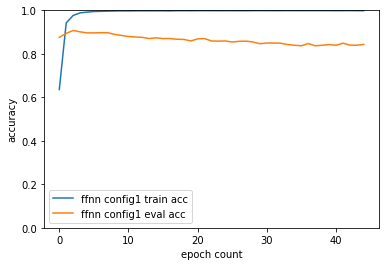

In [103]:
f1ta, = plt.plot(ffnn1tacc, label="ffnn config1 train acc")
f1ea, = plt.plot(ffnn1eacc, label="ffnn config1 eval acc")
plt.legend(handles=[f1ta, f1ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()

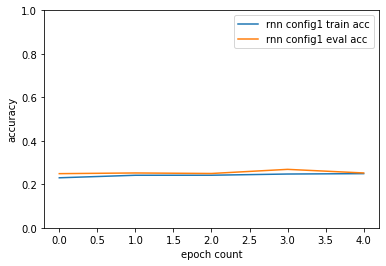

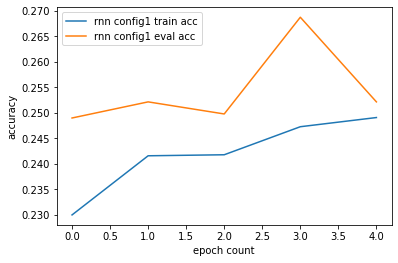

In [101]:
r1ta, = plt.plot(rnn1tacc, label="rnn config1 train acc")
r1ea, = plt.plot(rnn1eacc, label="rnn config1 eval acc")
plt.legend(handles=[r1ta, r1ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()
r1ta, = plt.plot(rnn1tacc, label="rnn config1 train acc")
r1ea, = plt.plot(rnn1eacc, label="rnn config1 eval acc")
plt.legend(handles=[r1ta, r1ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.show()

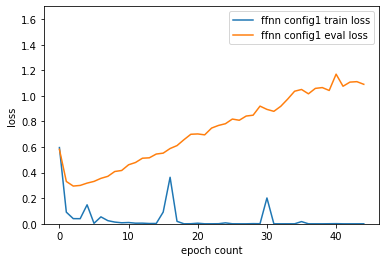

In [110]:
f1ts, = plt.plot(ffnn1tloss, label="ffnn config1 train loss")
f1es, = plt.plot(ffnn1eloss, label="ffnn config1 eval loss")
plt.legend(handles=[f1ts, f1es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 1.7)
plt.show()

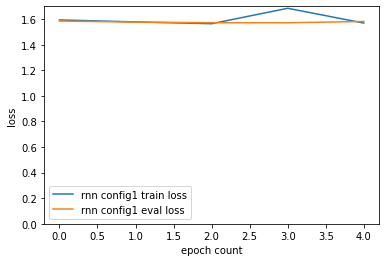

In [112]:
r1ts, = plt.plot(rnn1tloss, label="rnn config1 train loss")
r1es, = plt.plot(rnn1eloss, label="rnn config1 eval loss")
plt.legend(handles=[r1ts, r1es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 1.7)
plt.show()

_Nuanced quantitative analysis_

These are the base configurations for our models. At base, the FFNN takes about 2.6 seconds and the RNN takes about 27 seconds. We run multiple epochs of each to reach the same amount of time and use the same number of hidden features (512), batch size (16), and the same optimizer (adam, lr=.0003) in order to make a fair comparison.

Just above, you can see graphs of our results. The first two compare FFNN train accuracy vs evaluation accuracy. The second compares FFNN loss on training v evaluation. Similarly, the third and fourth graphs compare RNN train accuracy v evaluation accuracy and loss on train v evaluation. 

Our FFNN train accuracy runs as expected, however the evaluation accuracy actually decreases slightly over each epoch. As one would expect given these results, the loss for training decreases over time, but increases slightly for the evaluation.

Our RNN train and evaluation accuracy perform similarly, both slightly increasing over time, however the loss remains about the same.

Due to the limitations of RNN, the FFNN model outperforms our RNN model in both accuracy and loss.

### 3.1.2 Configuration 2
Modify the code below for this configuration.

In [ ]:
h = 256
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = convert_to_vector_representation(train, word2index)
val_vectorized = convert_to_vector_representation(val, word2index)
test_vectorized = convert_to_vector_representation(test, word2index, True)

train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)
ffnn_config_2 = FFNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
ffnn2tacc, ffnn2tloss, ffnn2eacc, ffnn2eloss = train_and_evaluate(71, ffnn_config_2, train_loader, val_loader)

In [ ]:
h = 256
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)

rnn_config_2 = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
rnn2tacc, rnn2tloss, rnn2eacc, rnn2eloss = train_and_evaluate_rnn(5, rnn_config_2, train_loader, val_loader)

In [80]:
print(ffnn2tacc, ffnn2tloss, ffnn2eacc, ffnn2eloss)
print(rnn2tacc, rnn2tloss, rnn2eacc, rnn2eloss)

[0.6001, 0.9321, 0.9718, 0.9841, 0.9899, 0.9925, 0.9942, 0.9959, 0.9968, 0.9967, 0.9972, 0.9975, 0.9974, 0.9977, 0.9978, 0.998, 0.9978, 0.9981, 0.9978, 0.9983, 0.9985, 0.9982, 0.9982, 0.9984, 0.9984, 0.9986, 0.9987, 0.9984, 0.9985, 0.9983, 0.9983, 0.9986, 0.9985, 0.9987, 0.9988, 0.9988, 0.9987, 0.9985, 0.9987, 0.9986, 0.9986, 0.9988, 0.9988, 0.9986, 0.9989, 0.9984, 0.9987, 0.9986, 0.9987, 0.9987, 0.9987, 0.9985, 0.9987, 0.9987, 0.9989, 0.9988, 0.9987, 0.9986, 0.9984, 0.9987, 0.999, 0.9987, 0.9984, 0.9988, 0.9987, 0.9987, 0.9987, 0.9989, 0.9987, 0.9989, 0.9987] [0.9452870488166809, 0.4307709038257599, 0.11400096863508224, 0.03446585312485695, 0.03243086114525795, 0.02384134754538536, 0.012805815786123276, 0.11520334333181381, 0.0038376699667423964, 0.002331039635464549, 0.0013807200593873858, 0.0089028375223279, 0.014852019026875496, 0.0014664959162473679, 0.00010882992501137778, 0.013112055137753487, 0.002101311692968011, 0.0006912993849255145, 0.0005901294061914086, 0.0002591933007352

### 3.1.2 Report
Describe configurations, report the results, and then perform a nuanced analysis

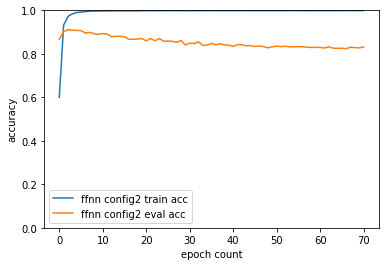

In [113]:
f2ta, = plt.plot(ffnn2tacc, label="ffnn config2 train acc")
f2ea, = plt.plot(ffnn2eacc, label="ffnn config2 eval acc")
plt.legend(handles=[f2ta, f2ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()

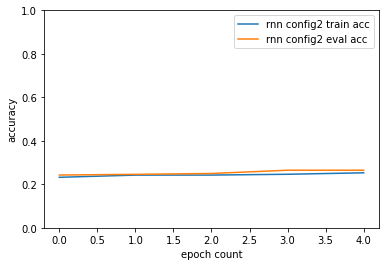

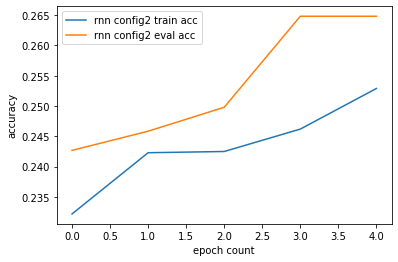

In [115]:
r2ta, = plt.plot(rnn2tacc, label="rnn config2 train acc")
r2ea, = plt.plot(rnn2eacc, label="rnn config2 eval acc")
plt.legend(handles=[r2ta, r2ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()
r2ta, = plt.plot(rnn2tacc, label="rnn config2 train acc")
r2ea, = plt.plot(rnn2eacc, label="rnn config2 eval acc")
plt.legend(handles=[r2ta, r2ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.show()

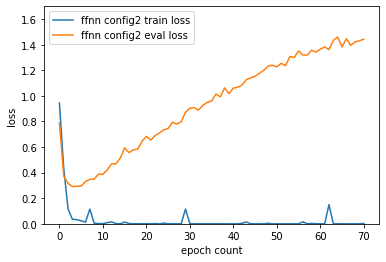

In [116]:
f2ts, = plt.plot(ffnn2tloss, label="ffnn config2 train loss")
f2es, = plt.plot(ffnn2eloss, label="ffnn config2 eval loss")
plt.legend(handles=[f2ts, f2es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 1.7)
plt.show()

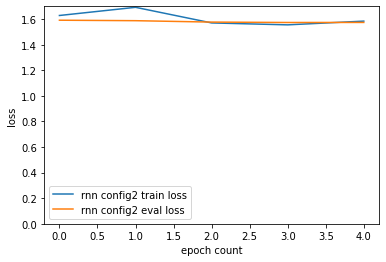

In [118]:
r2ts, = plt.plot(rnn2tloss, label="rnn config2 train loss")
r2es, = plt.plot(rnn2eloss, label="rnn config2 eval loss")
plt.legend(handles=[r2ts, r2es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 1.7)
plt.show()

_Nuanced quantitative analysis_

Configurations 2 use a hidden feature set of 256. The FFNN configuration 2 takes about 1.7 seconds. The RNN config 2 takes about 26 seconds. We run multiple epochs of each to reach the same amount of time. This configuration uses fewer hidden features (256), but keeps the batch size (16) and the same optimizer (adam, lr=.0003) the same in order to make a good comparison to the first configuration.

Just above, you can see graphs of our results. The first two compare FFNN train accuracy vs evaluation accuracy. The second compares FFNN loss on training v evaluation. Similarly, the third and fourth graphs compare RNN train accuracy v evaluation accuracy and loss on train v evaluation. /'

Our FFNN train accuracy runs as expected, however the evaluation accuracy actually decreases slightly over each epoch. As one would expect given these results, the loss for training decreases over time, but increases slightly for the evaluation.

Our RNN train and evaluation accuracy perform similarly, both slightly increasing over time, however the loss remains about the same. Looking more closely at our RNN's accuracy graph however, one can see that the evaluation accuracy significantly ourperforms the training accuracy at all epochs.

Due to the limitations of RNN, the FFNN model outperforms our RNN model in both accuracy and loss.

### 3.1.3 Configuration 3
Modify the code below for this configuration.

In [ ]:
h = 1024
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = convert_to_vector_representation(train, word2index)
val_vectorized = convert_to_vector_representation(val, word2index)
test_vectorized = convert_to_vector_representation(test, word2index, True)

train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)
ffnn_config_3 = FFNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
ffnn3tacc, ffnn3tloss, ffnn3eacc, ffnn3eloss = train_and_evaluate(71, ffnn_config_2, train_loader, val_loader)

In [ ]:
h = 1024
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=16)

rnn_config_3 = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
rnn3tacc, rnn3tloss, rnn3eacc, rnn3eloss = train_and_evaluate_rnn(5, rnn_config_2, train_loader, val_loader)

In [ ]:
print(ffnn3tacc, ffnn3tloss, ffnn3eacc, ffnn3eloss)
print(rnn3tacc, rnn3tloss, rnn3eacc, rnn3eloss)

### 3.1.3 Report
Describe configurations, report the results, and then perform a nuanced analysis

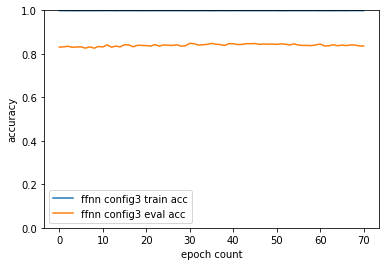

In [120]:
f3ta, = plt.plot(ffnn3tacc, label="ffnn config3 train acc")
f3ea, = plt.plot(ffnn3eacc, label="ffnn config3 eval acc")
plt.legend(handles=[f3ta, f3ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()

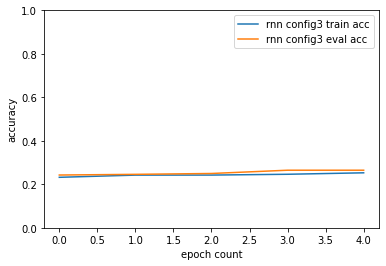

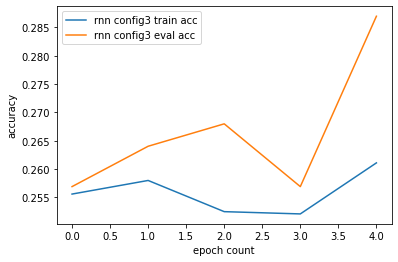

In [121]:
r3ta, = plt.plot(rnn2tacc, label="rnn config3 train acc")
r3ea, = plt.plot(rnn2eacc, label="rnn config3 eval acc")
plt.legend(handles=[r3ta, r3ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.ylim(0, 1)
plt.show()
r3ta, = plt.plot(rnn3tacc, label="rnn config3 train acc")
r3ea, = plt.plot(rnn3eacc, label="rnn config3 eval acc")
plt.legend(handles=[r3ta, r3ea])
plt.ylabel("accuracy")
plt.xlabel("epoch count")
plt.show()

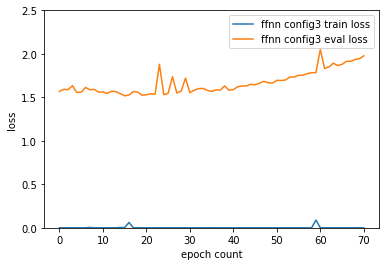

In [126]:
f3ts, = plt.plot(ffnn3tloss, label="ffnn config3 train loss")
f3es, = plt.plot(ffnn3eloss, label="ffnn config3 eval loss")
plt.legend(handles=[f3ts, f3es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 2.5)
plt.show()

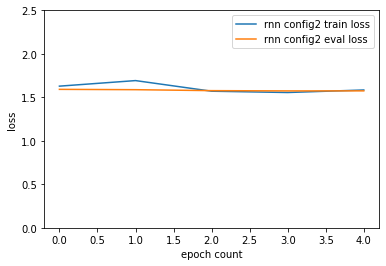

In [127]:
r2ts, = plt.plot(rnn2tloss, label="rnn config2 train loss")
r2es, = plt.plot(rnn2eloss, label="rnn config2 eval loss")
plt.legend(handles=[r2ts, r2es])
plt.ylabel("loss")
plt.xlabel("epoch count")
plt.ylim(0, 2.5)
plt.show()

_Nuanced quantitative analysis_

Configurations 3 use a hidden feature set of 1024. The FFNN configuration 3 takes about 1.8 seconds. The RNN config 3 takes about 25 seconds. This configuration uses more hidden features (1024), but keeps the batch size (16) and the same optimizer (adam, lr=.0003) the same in order to make a good comparison to the first two configurations.

Just above, you can see graphs of our results. The first two compare FFNN train accuracy vs evaluation accuracy. The second compares FFNN loss on training v evaluation. Similarly, the third and fourth graphs compare RNN train accuracy v evaluation accuracy and loss on train v evaluation. 

Our FFNN train accuracy and evaluation accuracy run as expected, however our training accuracy is much closer to perfect than our evaluation accuracy at all epochs. The evaluation accuracy only slighlty increases over time. As one would expect given these results, the loss for training stays near zero over time, but increases slightly for the evaluation after first decreasing slightly.

Our RNN train and evaluation accuracy perform similarly, both slightly increasing over time, however the loss remains about the same. Looking more closely at our RNN's accuracy graph however, one can see that the evaluation accuracy drops significantly at the 3rd epoch before going back up on the 4th. It also ourperforms the training accuracy at all epochs despite having higher losses at the end.

Due to the limitations of RNN, the FFNN model outperforms our RNN model in both accuracy and loss.


Overall, our analyses show that changing the number of hidden features does not significantly impact the performance of either model.


## Part 3.2: Within-model comparison
To complement **Part 3.1: Across-Model Comparison**, in **Part 3.2: Within-Model Comparison**, you will need to study what happens when you change parameters within a model. To limit your workload, you need only do this for the RNN; and you may use at most one RNN model from the prior section.

In the prior section, we discussed _fair comparison_. Anothr aspect of rigorous experimentation in NLP (and other domains) is the _ablation study_. In this, we _ablate_ or remove aspects of a more complex model, making it less complex, to evaluate whether each aspect was neccessary. To be concrete, for this part, you should train 4 variants of the RNN model and describe them as we do below:

1. Baseline model
2. Baseline model made more complex by modification $A$ (e.g. changing the hidden dimensionality from $h$ to $2h$).
3. Baseline model made more complex by modification $B$ (where $B$ is an entirely distinct/different update from $A$).
4. Baseline model with both modificatons $A$ and $B$ applied.

Under the framing of an ablation study, you woud describe this as beginning with model 4 and then ablating (i.e. removing) each of the two modifications, in turn; and then removing both to see if they were genuinely neccessary for the performance you observe.

Once you describe each of the four models, report the quantitative accuracy as in the previous section. Conclude by performing the **opposite** nuanced analysis from the one you did in the previous section (i.e. if in **Part 3.1: Across-Model Comparison** you did _Nuanced quanitative analysis_, for **Part 3.2: Within-Model Comparison** perform a _Nuanced qualitative analysis_ and vice versa).

### 3.2.1 Configuration 1
Modify the code below for this configuration.

In [ ]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=128)

baseline_rnn = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
rnnc1tacc, rnnc1tloss, rnnc1eacc, rnnc1eloss = train_and_evaluate_rnn(5, rnn_config_1, train_loader, val_loader)

### 3.2.1 Report
Describe variants in the ablation style described, report the results, and then perform a nuanced analysis of the opposite type as before.

In [93]:
print(rnnc1tacc, rnnc1tloss, rnnc1eacc, rnnc1eloss)

[0.2339, 0.2385, 0.2488, 0.249, 0.249] [1.5261167287826538, 1.5055145025253296, 1.5730197429656982, 1.5334091186523438, 1.631421685218811] [0.25533596837944667, 0.2545454545454545, 0.2490118577075099, 0.2426877470355731, 0.258498023715415] [1.592067837715149, 1.5858739614486694, 1.5876654386520386, 1.5847456455230713, 1.5720815658569336]


The baseline RNN uses 512 hidden layers, a batch size of 128, and a 50 feature word embedding trained on 6B tokens from wikipedia 2014 and gigaword 5. The final result was training accuracy of 25% and a loss of 1.6, and an evaulation accuracy of almost 26% and a loss of 1.57.

_Nuanced qualitative analysis_

We attempted to use many different types of sentences to see what this baseline RNN would predict the emotion was, however all of the sentences resulted in "joy".
Sentences we tried include: 

*   "i hate nlp" to get the hate emotion
*   "nlp is a scary class' to get the fear emotion
*   "i enjoy coding for nlp" to get the joy emotion
*   "nlp is my favorite class" to get the love emotion
*   "nlp makes me sad" to get the sad emotion

Some hypothesis for why this is as follows: our RNN must be heavily biased towards one emotion (joy). This would explain why our results are consistently only slightly above 20% (our RNN is heavily biased to 1/5 of the emotions and therefore predicts correctly 1 in 5 times).



### 3.2.2 Configuration 2
Modify the code below for this configuration.

In [ ]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=256)

mod_a_rnn = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
rnnc2tacc, rnnc2tloss, rnnc2eacc, rnnc2eloss = train_and_evaluate_rnn(5, rnn_config_1, train_loader, val_loader)

### 3.2.2 Report
Describe variants in the ablation style described, report the results, and then perform a nuanced analysis of the opposite type as before.

In [99]:
print(rnnc2tacc, rnnc2tloss, rnnc2eacc, rnnc2eloss)

[0.2566, 0.2542, 0.2525, 0.2576, 0.2538] [1.5943230390548706, 1.5493183135986328, 1.4506641626358032, 1.5588858127593994, 1.4211088418960571] [0.28063241106719367, 0.26324110671936757, 0.26403162055335966, 0.25691699604743085, 0.2758893280632411] [1.567955493927002, 1.5692830085754395, 1.570223093032837, 1.569632649421692, 1.563428282737732]


The 2nd configuration of RNN uses 512 hidden layers and the same 50 feature word embedding trained on 6B tokens from wikipedia 2014 and gigaword 5, but this time it used a batch size of 256. The final result was training accuracy of 25.4% and a loss of 1.4, and an evaulation accuracy of 27.5%% and a loss of 1.56.

_Nuanced qualitative analysis_

We attempted to use many different types of sentences to see what this baseline RNN would predict the emotion was, however all of the sentences resulted in "fear".
Sentences we tried include: 

*   "i hate nlp" to get the hate emotion
*   "nlp is a scary class' to get the fear emotion
*   "i enjoy coding for nlp" to get the joy emotion
*   "nlp is my favorite class" to get the love emotion
*   "nlp makes me sad" to get the sad emotion

Some hypothesis for why this is as follows: our RNN must be heavily biased towards one emotion (fear). This would explain why our results are consistently only slightly above 20% (our RNN is heavily biased to 1/5 of the emotions and therefore predicts correctly 1 in 5 times).



### 3.2.3 Configuration 3
Modify the code below for this configuration.

In [ ]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.twitter.27B.100d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 100)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index, embeddim=100)
val_vectorized = rnn_preprocessing(val, embedding, word2index, embeddim=100)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True, embeddim=100)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=128)

mod_b_rnn = RNN(len(vocab), h, len(emotion_to_idx), 100).to(get_device())
rnnc3tacc, rnnc3tloss, rnnc3eacc, rnnc3eloss =  train_and_evaluate_rnn(5, mod_b_rnn, train_loader, val_loader)

### 3.2.3 Report
Describe variants in the ablation style described, report the results, and then perform a nuanced analysis of the opposite type as before.

In [105]:
print(rnnc3tacc, rnnc3tloss, rnnc3eacc, rnnc3eloss)

[0.2322, 0.2444, 0.2474, 0.2485, 0.2495] [1.5306761264801025, 1.6360373497009277, 1.4925419092178345, 1.5993467569351196, 1.656813383102417] [0.25059288537549407, 0.25059288537549407, 0.27430830039525694, 0.25612648221343876, 0.26798418972332017] [1.590232253074646, 1.5857242345809937, 1.5789169073104858, 1.5779848098754883, 1.5724223852157593]


The 3rd configuration of RNN uses 512 hidden layers and the same batch size of 128 as the baseline, but instead of the 50 feature word embedding trained on 6B tokens from wikipedia 2014 and gigaword 5, this configuration uses a 100 feature word embedding trained on 26B tokens from 2B tweets.The final result was training accuracy of 25% and a loss of 1.65, and an evaulation accuracy of 25.7%% and a loss of 1.57.

_Nuanced qualitative analysis_

We attempted to use many different types of sentences to see what this baseline RNN would predict the emotion was, however all of the sentences resulted in "fear".
Sentences we tried include: 

*   "i hate nlp" to get the hate emotion
*   "nlp is a scary class' to get the fear emotion
*   "i enjoy coding for nlp" to get the joy emotion
*   "nlp is my favorite class" to get the love emotion
*   "nlp makes me sad" to get the sad emotion

Some hypothesis for why this is as follows: our RNN must be heavily biased towards one emotion (love). This would explain why our results are consistently only slightly above 20% (our RNN is heavily biased to 1/5 of the emotions and therefore predicts correctly 1 in 5 times).



### 3.2.4 Configuration 4
Modify the code below for this configuration.

In [ ]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.twitter.27B.100d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 100)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index, embeddim=100)
val_vectorized = rnn_preprocessing(val, embedding, word2index, embeddim=100)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True, embeddim=100)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=256)

both_mods_rnn = RNN(len(vocab), h, len(emotion_to_idx), embeddim=100).to(get_device())
rnnc4tacc, rnnc4tloss, rnnc4eacc, rnnc4eloss = train_and_evaluate_rnn(5, both_mods_rnn, train_loader, val_loader)

### 3.2.4 Report
Describe variants in the ablation style described, report the results, and then perform a nuanced analysis of the opposite type as before.

In [107]:
print(rnnc4tacc, rnnc4tloss, rnnc4eacc, rnnc4eloss)

[0.2263, 0.2359, 0.2421, 0.2486, 0.2531] [1.6506098508834839, 1.6512072086334229, 1.6259254217147827, 1.5611549615859985, 1.5773097276687622] [0.23715415019762845, 0.25059288537549407, 0.2450592885375494, 0.25217391304347825, 0.26956521739130435] [1.591841220855713, 1.5879100561141968, 1.586859107017517, 1.5876520872116089, 1.5700273513793945]


The 4th configuration of RNN uses 1024 hidden layers and a 100 feature word embedding trained on 26B tokens from 2B tweets. The final result was an accuracy of 22% and a loss of 4.8.

The 4th configuration RNN uses 512 hidden layers and the same batch size of 256 as the 2nd config and the 100 feature word embedding trained on 26B tokens from 2B tweets from the 3rd configuration. The final result was training accuracy of 25.3% and a loss of 1.577, and an evaulation accuracy of almost 27% and a loss of 1.57.

_Nuanced qualitative analysis_

Similar to the first three configurations, we attempted to use many different types of sentences to see what this baseline RNN would predict the emotion was. This time however we were not satisfied with getting all results the same emotion and running it multiple times, we found that although each time we train the model, the model results in the same emotion for each sentence we tried, this emotion varied. Running the baseline model again, we saw that instead of producing all joy, we got all fear, similarly for the 2nd and 3rd configuration, retraining the model led to a different single result.

This leads us to believe more strongly in our hypothesis that our RNN is heavily biased towards one emotion, and that our RNN must in some way be randomly learning this bias during training. As mentioned previously, this would explain why our results are consistently only slightly above 20% (our RNN is heavily biased to 1/5 of the emotions and therefore predicts correctly 1 in 5 times). It also explains our new finding that this bias changes each time we train the model. 

We do not know why the model is biased the way it is.



# Part 4: Questions
In **Part 4**, you will need to answer the three questions below. We expect answers tobe to-the-point; answers that are vague, meandering, or imprecise **will receive fewer points** than a precise but partially correct answer.

## 4.1 Q1
Earlier in the course, we studied models that make use of _Markov_ assumptions. Recurrent neural networks do not make any such assumption. That said, RNNs are known to struggle with long-distance dependencies. What is a fundamental reason for why this is the case?

The fundamental reason RNNs struggle with long-distance dependencies is because they work word by word, so as distances between dependencies increase, past information is lost.

## 4.2 Q2
In applying RNNs to tasks in NLP, we have discovered that (at least for tasks in English) feeding a sentence into an RNN backwards (i.e. inputting the sequence of vectors corresponding to ($course$, $great$, $a$, $is$, $NLP$) instead of ($NLP$, $is$, $a$, $great$, $course$)) tends to improve performance. Why might this be the case?

In English, Context-sensitive grammar exists, which means that with each word, there are left contexts and right contexts for how sentences are constructed. RNNs might be performing better when fed sentences backwards as a result of learning right contexts better than left contexts.


## 4.3 Q3
In using RNNs and word embeddings for NLP tasks, we are no longer required to engineer specific features that are useful for the task; the model discovers them automatically. Stated differently, it seems that neural models tend to discover better features than human researchers can directly specify. This comes at the cost of systems having to consume tremendous amounts of data to learn these kinds of patterns from the data. Beyond concerns of dataset size (and the computational resources required to process and train using this data as well as the further environmental harm that results from this process), why might we disfavor RNN models?

Besides the previously listed concerns, another reason we might disfavor RNN models would be difficulty controlling biases. Since neural nets discover features automattically, it might be more difficult to prevent the model from learning unwanted biases that occur in society like racism and sexism. These biases would be learned during training as a result of the societal bias in the data, something that would be hard to control for since a lot of data is necessary for these models to do well.

# Part 5: Miscellaneous
List the libraries you used and sources you referenced and cited (labelled with the section in which you referred to them). Include a description of how your group split
up the work. Include brief feedback on this asignment.

The only source referenced that was not class notes, the class textbook, the OH torch tutorial, or official documentation was:

https://androidkt.com/pre-train-word-embedding-in-pytorch/

This source was used to help obtain and use the pretrained glove embeddings.

We took turns pair programming, with one partner typing up code while the other dictated the code and ideas for what to implement. All work was done together.

**Each section must be clearly labelled, complete, and the corresponding pages should be correctly assigned to the corresponding Gradescope rubric item.** If you follow these steps for each of the 4 components requested, you are guaranteed full credit for this section. Otherwise, you will receive no credit for this section.

# Part 6: Kaggle Submission

In [78]:
h = 512
glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4740", "Project 3", "glove.6B.50d.txt") # replace based on your Google drive organization
glove = pd.read_csv(glove_path, sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
embMatrix = create_embedding_matrix(word2index, glove_embedding, 50)
emb_vocab_size = embMatrix.shape[0]
emb_vector_size = embMatrix.shape[1]
embedding = nn.Embedding(emb_vocab_size, emb_vector_size)
embedding.weight=nn.Parameter(torch.tensor(embMatrix,dtype=torch.float32))
train, val, test = fetch_data(train_path, val_path, test_path)
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = rnn_preprocessing(train, embedding, word2index)
val_vectorized = rnn_preprocessing(val, embedding, word2index)
test_vectorized = rnn_preprocessing(test, embedding, word2index, True)
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=1)

rnn_config_1 = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())


In [79]:
# Create Kaggle submission function
kaggle_model = RNN(len(vocab), h, len(emotion_to_idx)).to(get_device())
# rnn_document_preprocessor = lambda x: rnn_preprocessor(x, True) # This is for your RNN
rnn_document_preprocessor = lambda x: rnn_preprocessing(x, embedding, word2index, True, embeddim=50) # This is for your RNN

file_name = "submission.csv"
ffnn_document_preprocessor = lambda x: convert_to_vector_representation(x, word2index, True)

In [ ]:
def generate_submission(filename, model, document_preprocessor, test):
    test_vectorized = document_preprocessor(test)
    with Path(file_name).open("w") as fp:
        fp.write("Id,Predicted\n")
        for idx, input_vector in tqdm(enumerate(test_vectorized), total=len(test_vectorized)):
            # print("iv", input_vector.size(), input_vector)
            output = model(torch.Tensor(input_vector).unsqueeze(0).to(get_device())).cpu()#.squeeze(0)
            _, pred = torch.max(output, 1)
            fp.write(f"{idx},{int(pred)}\n")
    return

In [ ]:
generate_submission(file_name, kaggle_model, rnn_document_preprocessor, test)

# Live running demo

In [84]:
#@title Emotion Detection
#@markdown Enter a sentence to see the emotion
input_string = "i love nlp" #@param {type:"string"}
model_type = "baseline_rnn" #@param ["baseline_ffnn", "baseline_rnn", "mod_a_rnn", "mod_b_rnn", "both_mods_rnn", "ffnn_config_1", "rnn_config_1", "ffnn_config_2", "rnn_config_2", "ffnn_config_3", "rnn_config_3"]
from IPython.display import HTML

output = ""

# BAD THING TO DO BELOW!!
model_used = globals()[model_type]

with torch.no_grad():
    if "ffnn" in model_type:
        vec_in = ffnn_document_preprocessor([[input_string]])[0]
        model_output = model_used(torch.Tensor(vec_in).unsqueeze(0)).cpu().squeeze(0)
    else:
        # RUN MODEL
        vec_in = rnn_document_preprocessor([[input_string]])[0]
        model_output = model_used(torch.Tensor(vec_in).unsqueeze(0)).cpu().squeeze(0)
    #print(torch.cat([torch.Tensor(z).unsqueeze(0) for z in model_inputs]).unsqueeze(0).shape)
    #model_output = model_used(torch.cat([torch.Tensor(z).unsqueeze(0) for z in model_inputs]).unsqueeze(0))
    #print(model_output.shape)
predicted = torch.argmax(model_output)
# MAP BACK TO EMOTION
# print(int(predicted))
emotion = idx_to_emotion[int(predicted)]

# Generate nice display
output += '<p style="font-family:verdana; font-size:110%;">'
output += " Input sequence: "+input_string+"</p>"
output += '<p style="font-family:verdana; font-size:110%;">'
output += f" Emotion detected: {emotion}</p><hr>"
output = "<h3>Results:</h3>" + output

display(HTML(output))